# Project about making business decisions based on data

## Project description

We are an analyst at a big online store. Together with the marketing department, we've compiled a list of hypotheses that may help boost revenue.
We need to prioritize these hypotheses, launch an A/B test, and analyze the results.

## Description of the data

**Data used in the first part of the project**

/datasets/hypotheses_us.csv
- *Hypotheses* — brief descriptions of the hypotheses
- *Reach* — user reach, on a scale of one to ten
- *Impact* — impact on users, on a scale of one to ten
- *Confidence* — confidence in the hypothesis, on a scale of one to ten
- *Effort* — the resources required to test a hypothesis, on a scale of one to ten. The higher the Effort value, the more resource-intensive the test.



**Data used in the second part of the project**

/datasets/orders_us.csv
- *transactionId* — order identifier
- *visitorId* — identifier of the user who placed the order
- *date* — of the order
- *revenue* — from the order
- *group* — the A/B test group that the user belongs to

/datasets/visits_us.csv
- *date* — date
- *group* — A/B test group
- *visits* — the number of visits on the date specified in the A/B test group specified

## Loading and preprocessing the data

In [1]:
import pandas as pd
from scipy import stats as st
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import plotly.express as px
from scipy import stats
import warnings

warnings.filterwarnings(action='ignore')

In [2]:
hypotheses=pd.read_csv('/datasets/hypotheses_us.csv', sep=';')
orders=pd.read_csv('/datasets/orders_us.csv')
visits=pd.read_csv('/datasets/visits_us.csv')

### Preprocessing the data of hypotheses

In [3]:
hypotheses

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


In [4]:
hypotheses.columns=hypotheses.columns.str.lower()

### Preprocessing the data of users

In [5]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


In [7]:
orders['date']=pd.to_datetime(orders['date'],format='%Y-%m-%d')

In [8]:
visits.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [9]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [10]:
visits['date']=pd.to_datetime(visits['date'],format='%Y-%m-%d')

#### Let's check number groups:

In [11]:
orders['group'].unique()

array(['B', 'A'], dtype=object)

In [12]:
orders.groupby('group').nunique()

,transactionId,visitorId,date,revenue
group,,,,
A,557,503,31,277
B,640,586,31,292


Let's find what period data is available to us:

In [13]:
orders['date'].min()

Timestamp('2019-08-01 00:00:00')

In [14]:
orders['date'].max()

Timestamp('2019-08-31 00:00:00')

In [15]:
visits['date'].min()

Timestamp('2019-08-01 00:00:00')

In [16]:
visits['date'].max()

Timestamp('2019-08-31 00:00:00')

**We see that the observations were carried out within one month.**

#### Let's check if there are users in both groups:

In [17]:
datacheck=orders.groupby('visitorId')['group'].nunique().reset_index()
datacheck.sort_values(by='group', ascending='True')

,visitorId,group
0,5114589,1
666,2738601405,1
667,2742574263,1
668,2743474511,1
669,2744017357,1
...,...,...
55,237748145,2
340,1404934699,2
406,1668030113,2
661,2712142231,2


In [18]:
ABusers=datacheck[datacheck['group']==2]['visitorId']
ABusers.head()

2       8300375
44    199603092
51    232979603
55    237748145
66    276558944
Name: visitorId, dtype: int64

In [19]:
print('number users is in both group =',ABusers.nunique())

number users is in both group = 58


In [20]:
print('percente users is in both group = ','{:.1f}'.format(ABusers.nunique()/datacheck.shape[0]*100),'%')

percente users is in both group =  5.6 %


**And although number quite big part of all data and we should remove these users for right A/B testing.**

In [21]:
orders=orders[np.logical_not(orders['visitorId'].isin(ABusers))]

In [22]:
orders.groupby('visitorId')['group'].nunique().reset_index().sort_values(by='group')

,visitorId,group
0,5114589,1
640,2772153338,1
641,2776274025,1
642,2785040378,1
643,2785527055,1
...,...,...
329,1426761187,1
330,1430210707,1
331,1438226485,1
303,1335154194,1


#### Let's look on distribution of data:

In [23]:
visitsA=visits[visits['group']=='A']
visitsA.describe()

,visits
count,31.000000
mean,604.387097
std,112.396227
min,361.000000
25%,541.000000
50%,619.000000
75%,705.000000
max,756.000000


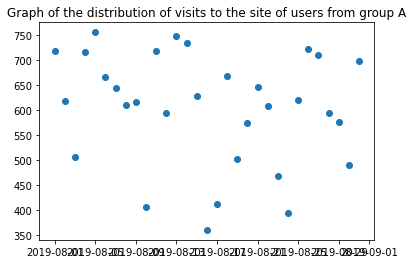

In [24]:
plt.scatter(visitsA['date'],visitsA['visits'])
plt.title('Graph of the distribution of visits to the site of users from group A')
plt.show()

In [25]:
visitsB=visits[visits['group']=='B']
visitsB.describe()

,visits
count,31.000000
mean,610.193548
std,118.156230
min,369.000000
25%,537.000000
50%,654.000000
75%,711.000000
max,770.000000


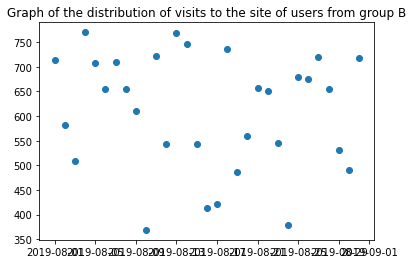

In [26]:
plt.scatter(visitsB['date'],visitsB['visits'])
plt.title('Graph of the distribution of visits to the site of users from group B')
plt.show()

**According to the schedules of the distribution of visits and indicators of standard deviations and others, we can say that the sizes and activity of the groups are very close, the rest of the conclusions will be made after the AB test.**

## Part 1. Prioritizing Hypotheses

In [27]:
print(hypotheses['hypothesis'][0])
print(hypotheses['hypothesis'][1])
print(hypotheses['hypothesis'][2])
print(hypotheses['hypothesis'][3])
print(hypotheses['hypothesis'][4])
print(hypotheses['hypothesis'][5])
print(hypotheses['hypothesis'][6])
print(hypotheses['hypothesis'][7])
print(hypotheses['hypothesis'][8])

Add two new channels for attracting traffic. This will bring 30% more users
Launch your own delivery service. This will shorten delivery time
Add product recommendation blocks to the store's site. This will increase conversion and average purchase size
Change the category structure. This will increase conversion since users will find the products they want more quickly
Change the background color on the main page. This will increase user engagement
Add a customer review page. This will increase the number of orders
Show banners with current offers and sales on the main page. This will boost conversion
Add a subscription form to all the main pages. This will help you compile a mailing list
Launch a promotion that gives users discounts on their birthdays


### ICE framework to prioritize hypotheses

In [28]:
hypotheses['ICE']=(hypotheses['impact']*hypotheses['confidence']/hypotheses['effort']).map(lambda x:"{0:.0f}".format(x))

In [29]:
pd.options.display.max_colwidth = 210
hypotheses.sort_values(by='ICE', ascending=False)

,hypothesis,reach,impact,confidence,effort,ICE
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3,8
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3,7
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10,2
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5,16
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6,13
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5,11
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8,1
4,Change the background color on the main page. This will increase user engagement,3,1,1,1,1
5,Add a customer review page. This will increase the number of orders,3,2,2,3,1


 ### RICE framework to prioritize hypotheses

In [30]:
hypotheses['RICE']=(hypotheses['reach']*hypotheses['impact']*hypotheses['confidence']/hypotheses['effort']).map(lambda x:"{0:.0f}".format(x))

In [31]:
pd.options.display.max_colwidth = 210
hypotheses.sort_values(by='RICE', ascending=False)

,hypothesis,reach,impact,confidence,effort,ICE,RICE
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8,1,9
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3,7,56
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6,13,40
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3,8,40
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10,2,4
5,Add a customer review page. This will increase the number of orders,3,2,2,3,1,4
4,Change the background color on the main page. This will increase user engagement,3,1,1,1,1,3
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5,16,16
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5,11,112


### Consilusions

  ***When prioritizing hypotheses for ICE and RICE, we see different results, since RICE takes into account an additional parameter - reach.***<br> 
  
And if we take **hypothesis 9 about the birthday**, then in the **ICE prioritization it is on the top line**, and in the **RICE it drops to the fifth**, because, despite the high parameters of impact, confidence and little effort, it has a very low reach, because each client this The action will draw only once a year on his birthday. Thus, the increase in the number of orders will not be as strong as it might seem based only on the ICE rating. However, if the task is not to increase orders at the moment, but to increase the activity of old customers, "remind yourself" and possibly increase the number of orders in the future, then the ICE rating will do just fine.<br>

If we consider **hypothesis 1 about adding two new channels**, then it is quite **high in both ratings**, since an increase in additional customers by 30% is a fairly large reach.<br>

Also quite **high in both ratings**, in ICE in the first place, in RICE in second place is **hypothesis 8 about the addition of subscription forms**. This happened because it has high coverage - all site users will see this form, high impact - because when adding the form to all pages of the site, the user will see the form all the time and think about subscribing and high confidence, since apparently it has already been analyzes of customer behavior when adding subscription forms earlier or in other companies.<br>

In the **RICE ranking, hypothesis 3 about adding product recommendations** to the site is in **second place**, because the reach of this hypothesis is high. This is due to the fact that all site users will see these blocks. But on the other hand, in the **ICE rating**, this hypothesis is quite low - **in fifth place**, since the impact of this hypothesis is quite low - after all, not many customers, having seen the recommendations, immediately rush to place an order.<br>

**The lowest position in both ratings** belongs to **hypothesis 5 about background change**. Since this hypothesis has very low scores: coverage because most customers will not pay attention to the background color, impact because it is unlikely that someone will change user behavior due to the background color, certainty because there are no studies on the amount people who pay attention and change their customer behavior due to the background on the site.

## Part 2. A/B Test Analysis

### Lets graph cumulative revenue by group. 

In [32]:
#to create a DataFrame called with unique paired 'date' and 'group'
datesGroups=orders[['date','group']].drop_duplicates()

Let's collect the aggregated cumulative daily data on orders

In [33]:
ordersAggregated=datesGroups.apply(lambda x:orders[np.logical_and(orders['date'] <= x['date'],orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : pd.Series.nunique, 'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [34]:
visitsAggregated=datesGroups.apply(lambda x:visits[np.logical_and(visits['date'] <= x['date'],visits['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visits' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [35]:
cumulativeData = ordersAggregated.merge(visitsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

In [36]:
cumulativeData.columns=['date','group','transactions','buyers','revenue','visits']

In [37]:
cumulativeRevenueA=cumulativeData[cumulativeData['group']=='A'][['date','revenue','transactions']]
cumulativeRevenueB=cumulativeData[cumulativeData['group']=='B'][['date','revenue','transactions']]

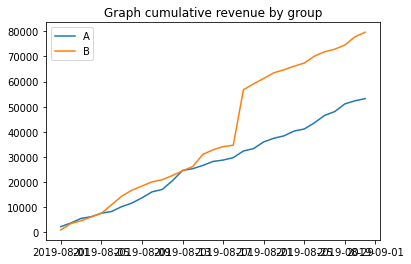

In [38]:
plt.plot(cumulativeRevenueA['date'],cumulativeRevenueA['revenue'],label='A')
plt.plot(cumulativeRevenueB['date'],cumulativeRevenueB['revenue'],label='B')
plt.legend() 
plt.title('Graph cumulative revenue by group')
plt.show()

***Conclusions:*** Cumulative revenue of group B  is bigger than cumulative revenue of group A, except of testing begining . And with time this difference increase. But in group B we see spike in revenue, this may imply either a surge in the number of orders or the presence of very expensive orders in the sample. That could be outliers.

### Lets graph cumulative average order size by group.

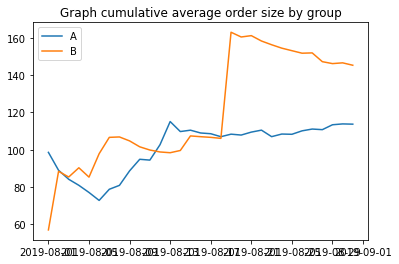

In [39]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['transactions'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['transactions'], label='B')
plt.legend()
plt.title('Graph cumulative average order size by group')
plt.show()

***Conclusions:*** Cumulative average order size is unstability in both groups, especialy in group B in second parts of testing.
It may have been due to the presence of large, expensive orders. We need more data on this group to find the true average purchase size and establish its level.

### Graph the relative difference in cumulative average order size for group B compared with group A.

In [40]:
mergedCumulativeRevenue=cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
mergedCumulativeRevenue.head()

,date,revenueA,transactionsA,revenueB,transactionsB
0,2019-08-01,2266.6,23,967.2,17
1,2019-08-02,3734.9,42,3535.3,40
2,2019-08-03,5550.1,66,4606.9,54
3,2019-08-04,6225.6,77,6138.5,68
4,2019-08-05,7623.6,99,7587.8,89


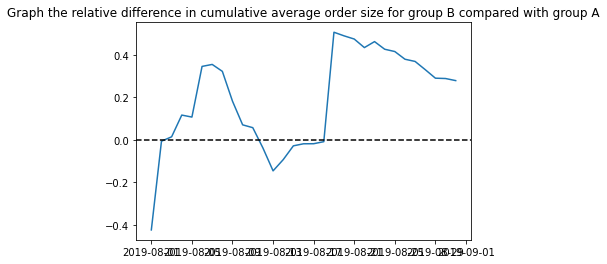

In [41]:
plt.plot(mergedCumulativeRevenue['date'],(mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['transactionsB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['transactionsA'])-1)
plt.axhline(y=0, color='black', linestyle='--') 
plt.title('Graph the relative difference in cumulative average order size for group B compared with group A')
plt.show()

***Conclusions:*** At several points the difference between the segments spikes. This means there must be some big orders and outliers.

### Graph the daily conversion rates of the two groups.

#### Cummulitive daily conversion rates.

In [42]:
cumulativeData['conversion']=cumulativeData['transactions']/cumulativeData['visits']
cumulativeData.head()

,date,group,transactions,buyers,revenue,visits,conversion
0,2019-08-01,A,23,19,2266.6,719,0.031989
1,2019-08-01,B,17,17,967.2,713,0.023843
2,2019-08-02,A,42,36,3734.9,1338,0.031390
3,2019-08-02,B,40,39,3535.3,1294,0.030912
4,2019-08-03,A,66,60,5550.1,1845,0.035772


In [43]:
cumulativeDataA=cumulativeData[cumulativeData['group']=='A']
cumulativeDataB=cumulativeData[cumulativeData['group']=='B']

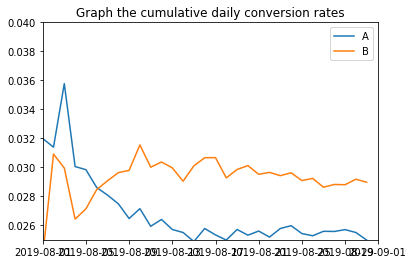

In [44]:
plt.plot(cumulativeDataA['date'],cumulativeDataA['conversion'],label='A')
plt.plot(cumulativeDataB['date'],cumulativeDataB['conversion'],label='B')
plt.legend()
plt.axis([pd.to_datetime('2019-08-01'), pd.to_datetime('2019-09-01'), 0.025, 0.04])
plt.title('Graph the cumulative daily conversion rates')
plt.show()

***Conclusions:*** Conversion rate of group B is bigger than of group A in testing, except beginning. In the beginning conversion rate of group A is high, but after that it is sharp decrease.

#### The daily conversion rates.

In [45]:
Data = orders.merge(visits, left_on=['date', 'group'], right_on=['date', 'group']).groupby(['date','group']).agg({'visitorId':pd.Series.nunique,'transactionId':pd.Series.nunique,'revenue':sum,'visits':sum}).reset_index()
Data.columns=['date','group','buyers','transactions','revenue','visits']
Data.head()

,date,group,buyers,transactions,revenue,visits
0,2019-08-01,A,19,23,2266.6,16537
1,2019-08-01,B,17,17,967.2,12121
2,2019-08-02,A,18,19,1468.3,11761
3,2019-08-02,B,22,23,2568.1,13363
4,2019-08-03,A,24,24,1815.2,12168


In [46]:
#deviding data on groups
DataA=Data[Data['group']=='A']
DataB=Data[Data['group']=='B']

In [47]:
DataA['conversion']=DataA['buyers']/DataA['visits']
DataA.head()

,date,group,buyers,transactions,revenue,visits,conversion
0,2019-08-01,A,19,23,2266.6,16537,0.001149
2,2019-08-02,A,18,19,1468.3,11761,0.001530
4,2019-08-03,A,24,24,1815.2,12168,0.001972
6,2019-08-04,A,11,11,675.5,7887,0.001395
8,2019-08-05,A,22,22,1398.0,16632,0.001323


In [48]:
DataB['conversion']=DataB['buyers']/DataB['visits']
DataB.head()

,date,group,buyers,transactions,revenue,visits,conversion
1,2019-08-01,B,17,17,967.2,12121,0.001403
3,2019-08-02,B,22,23,2568.1,13363,0.001646
5,2019-08-03,B,14,14,1071.6,7126,0.001965
7,2019-08-04,B,13,14,1531.6,10780,0.001206
9,2019-08-05,B,21,21,1449.3,14847,0.001414


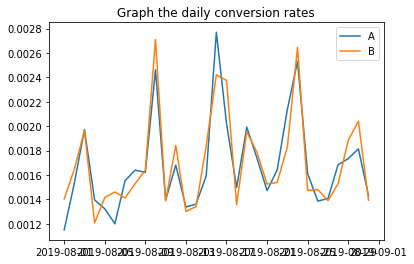

In [49]:
plt.plot(DataA['date'],DataA['conversion'],label='A')
plt.plot(DataB['date'],DataB['conversion'],label='B')
plt.legend()
plt.title('Graph the daily conversion rates')
plt.show()

***Conclusions:*** The graph shows that the daily conversion of the groups corresponds to each other. The groups have the same peaks but the daily conversion of group B is quite a bit higher than the daily conversion of group A.

### Plot a scatter chart of the number of orders per user.

In [50]:
ordersByUsers = (orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique}))
ordersByUsers.columns = ['userId', 'orders']
ordersByUsers

,userId,orders
0,5114589,1
1,6958315,1
2,11685486,1
3,39475350,1
4,47206413,1
...,...,...
968,4259830713,1
969,4278982564,1
970,4279090005,1
971,4281247801,1


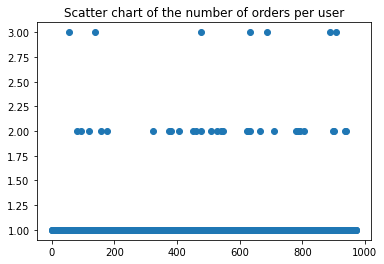

In [51]:
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Scatter chart of the number of orders per user')
plt.show()

 ***Conclusions:*** There are very few users with more than 1 orders. It could be outliers.

### Let's find point, where data becomes an anomaly. 

Calculate the 95th and 99th percentiles for the number of orders per user.

In [52]:
np.percentile(ordersByUsers['orders'], [95,99])

array([1., 2.])

***Conclusions:*** It means that only 5 % of users have more than 1 orders and only 1 % - more than 2. Let's say that point of anomaly 2 orders.

In [53]:
visitorIdOutliers=ordersByUsers[ordersByUsers['orders']>=2]['userId']
visitorIdOutliers.head()

55     249864742
82     366673373
94     406208401
118    522292794
138    611059232
Name: userId, dtype: int64

### Plot a scatter chart of order prices.

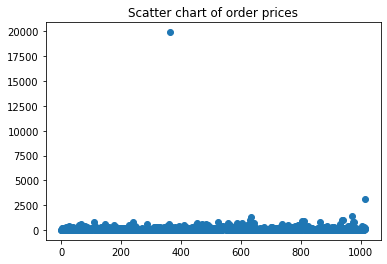

In [54]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values,orders['revenue'])
plt.title('Scatter chart of order prices')
plt.show()

***Conclusions:***There are only 2 orders have price much bigger than others - about 20000 and 3000. The most orders have prices to 2500.

### Let's find point, where data becomes an anomaly.

In [55]:
np.percentile(orders['revenue'], [95,99])

array([414.275, 830.3  ])

***Conclusions:*** It means that only 5 % of orders have price more than 435 and only 1 % - more than 900. Let's say that point of anomaly of price - 900.

In [56]:
transactionIdOutliers=orders[orders['revenue']>=900]['transactionId']
transactionIdOutliers

425      590470918
743     3603576309
744     3668308183
940     2420050534
949     1347999392
1099     316924019
1103    1348774318
1136     666610489
1196    3936777065
Name: transactionId, dtype: int64

### Let's find the statistical significance of the difference in conversion between the groups.

Lets formulate null and an alternative hypothesises: <br>
 ***H0:The null hypothesis - Conversions of the groups are statistical equal.<br>
    H1:The alternative hypothesis - Conversions of the groups have statistical significance difference.***

#### Finding the statistical significance of the difference in total conversion rate:

In [57]:
trialsA=DataA['visits'].sum()
print('trials for A group', trialsA)

trials for A group 284206


In [58]:
successesA=DataA['buyers'].sum()
print('sucsses for A group', successesA)

sucsses for A group 457


In [59]:
print('total conversion for A group', successesA/trialsA)

total conversion for A group 0.001607988571669845


In [60]:
trialsB=DataB['visits'].sum()
print('trials for B group', trialsB)

trials for B group 331836


In [61]:
successesB=DataB['buyers'].sum()
print('sucsses for B group', successesB)

sucsses for B group 544


In [62]:
print('total conversion for B group', successesB/trialsB)

total conversion for B group 0.0016393640231921792


In [63]:
#lets find statistical significance
from statsmodels.stats.proportion import proportions_ztest
stat, pval = proportions_ztest([successesA,successesB], [trialsA,trialsB])
print('{0:0.3f}'.format(pval))


0.761


***Conclusions:*** The p-value is higher than a=0.05, so we can't reject our null hypothesis and group's conversion rates haven't statistically significant differences.

#### Finding the statistical significance of the difference in daily conversion rate:

In [64]:
#Function for checking average
def testing_average(sample1,sample2,alpha=0.05):
    #checking normality
    sample1=sample1.dropna()
    sample2=sample2.dropna()
    stat1, p1_norm=stats.shapiro(sample1)
    stat2, p2_norm=stats.shapiro(sample2)
    if p1_norm > alpha and p2_norm>alpha:
        #then both normal, perform t-test.
        #for t-test also should check the equality of variances
        statslev,p_levene=stats.levene(sample1, sample2)
        if p_levene<alpha:
           #variances are not equal
            statist,p_value=stats.ttest_ind(sample1, sample2,equal_var=False)
        else:
            statist,p_value=stats.ttest_ind(sample1, sample2,equal_var=True) 
    else:
        statist,p_value=stats.mannwhitneyu(sample1, sample2)
    print(p_value)
    if p_value<alpha:
        print('Reject H0')
    else:
        print('Fail to Reject H0')

In [65]:
testing_average(DataA['conversion'],DataB['conversion'],alpha=0.05)

0.9663095151069797
Fail to Reject H0


***Conclusions:*** The same result for daily conversion  - the p-value is near 1, so we can't reject our null hypothesis and group's daily conversion rates haven't statistically significant differences.

### Let's find the statistical significance of the difference in average order size between the groups. 

Lets formulate null and an alternative hypothesises: <br>
 ***H0:The null hypothesis - Averages orders sizes of the groups are statistical equal.<br>
    H1:The alternative hypothesis -Averages orders sizes of the groups have statistical significance difference.***

Let's count average order size in the day.

In [66]:
DataA['avg_ch']=DataA['revenue']/DataA['transactions']
DataA.head()

,date,group,buyers,transactions,revenue,visits,conversion,avg_ch
0,2019-08-01,A,19,23,2266.6,16537,0.001149,98.547826
2,2019-08-02,A,18,19,1468.3,11761,0.001530,77.278947
4,2019-08-03,A,24,24,1815.2,12168,0.001972,75.633333
6,2019-08-04,A,11,11,675.5,7887,0.001395,61.409091
8,2019-08-05,A,22,22,1398.0,16632,0.001323,63.545455


In [67]:
DataB['avg_ch']=DataB['revenue']/DataB['transactions']
DataB.head()

,date,group,buyers,transactions,revenue,visits,conversion,avg_ch
1,2019-08-01,B,17,17,967.2,12121,0.001403,56.894118
3,2019-08-02,B,22,23,2568.1,13363,0.001646,111.656522
5,2019-08-03,B,14,14,1071.6,7126,0.001965,76.542857
7,2019-08-04,B,13,14,1531.6,10780,0.001206,109.400000
9,2019-08-05,B,21,21,1449.3,14847,0.001414,69.014286


In [68]:
average_checkA=DataA['avg_ch'].mean()
print('average order for group A',average_checkA)

average order for group A 115.5124717608274


In [69]:
average_checkB=DataB['avg_ch'].mean()
print('average order for group B',average_checkB)

average order for group B 138.3711696835165


In [70]:
testing_average(DataA['avg_ch'],DataB['avg_ch'],alpha=0.05)

0.9550914317372012
Fail to Reject H0


***Conclusions:*** The p-value is near 1, so we can't reject our null hypothesis and group's average check haven't statistically significant differences.

### Let's find the statistical significance of the difference in conversion between the groups using the filtered data.

Let's create the filtered data.
Let's create filtered data for users who have made more than 3 orders and for orders worth more than 900, since these data are anomalous.

In [71]:
ordersNew=orders[np.logical_not(orders['transactionId'].isin(transactionIdOutliers))][np.logical_not(orders['visitorId'].isin(visitorIdOutliers))]
ordersNew

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B
...,...,...,...,...,...
1190,38478481,1197745035,2019-08-14,135.3,B
1191,3592955527,608641596,2019-08-14,255.7,B
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A


In [72]:
DataNew=ordersNew.merge(visits, left_on=['date', 'group'], right_on=['date', 'group']).groupby(['date','group']).agg({'visitorId':pd.Series.nunique,'transactionId':pd.Series.nunique,'revenue':sum,'visits':sum}).reset_index()
DataNew.columns=['date','group','buyers','transactions','revenue','visits']
DataNew['conversion']=DataNew['buyers']/DataNew['visits']
DataNew

,date,group,buyers,transactions,revenue,visits,conversion
0,2019-08-01,A,15,15,1427.4,10785,0.001391
1,2019-08-01,B,17,17,967.2,12121,0.001403
2,2019-08-02,A,15,15,762.2,9285,0.001616
3,2019-08-02,B,20,20,2432.3,11620,0.001721
4,2019-08-03,A,24,24,1815.2,12168,0.001972
...,...,...,...,...,...,...,...
57,2019-08-29,B,14,14,1651.1,7434,0.001883
58,2019-08-30,A,7,7,528.2,3430,0.002041
59,2019-08-30,B,21,21,3286.8,10290,0.002041
60,2019-08-31,A,8,8,848.3,5592,0.001431


In [73]:
#deviding data on groups
DataNewA=DataNew[DataNew['group']=='A']
DataNewB=DataNew[DataNew['group']=='B']

In [74]:
testing_average(DataNewA['conversion'],DataNewB['conversion'],alpha=0.05)

0.7301376549390499
Fail to Reject H0


***Conclusions:*** p-value for filtred data a little bit lower than for full data, but it is near 1, so we have the same result - we can't reject our null hypothesis and group's daily conversion rates haven't statistically significant differences.

### Let's find the statistical significance of the difference in average order size between the groups using the filtered data.

In [75]:
DataNewA['avg_ch']=DataNewA['revenue']/DataNewA['transactions']
DataNewB['avg_ch']=DataNewB['revenue']/DataNewB['transactions']

In [76]:
new_average_checkA=DataNewA['avg_ch'].mean()
print('average order for filtred group A',new_average_checkA)

average order for filtred group A 101.60165594607409


In [77]:
new_average_checkB=DataNewB['avg_ch'].mean()
print('average order for filtred  group B',new_average_checkB)

average order for filtred  group B 100.73493120319829


In [78]:
testing_average(DataNewA['avg_ch'],DataNewB['avg_ch'],alpha=0.05)

0.9261905382178917
Fail to Reject H0


***Conclusions:*** The p-value higher than a=0.05, so we can't reject our null hypothesis and can say that group's averages checks haven't statistically significant differences.

### Conclusions

**We made analytical studies of two groups A and B.** <b>
1) Considered their cumulative characteristics such as: income, average order size, conversion. And we can conclude:<b>
- At the very beginning of the analysis period, in the first few days, the cumulative income of group A exceeds the cumulative income of group B. Throughout the rest of the analysis, **the cumulative income of group B is greater** and grows faster than that of group A.
- The situation is similar with the cumulative size of the order - in the first days for group A it is higher than for B and drops sharply, while for B it grows. With the exception of the period after 1.5 -2 weeks of observations, where the average order of A again exceeds B, at all other times **the size of the order of B is much larger**.
- The same thing happens with cumulative conversion rates. With the exception of the first days, **the cumulative conversion of group B is higher** than that of group A.<b>
    
2) To determine the statistical significance of group differences, we used the Z-test and the Mann-Whitney U test:<b>
- When testing for the statistical significance of differences in conversions, we get **p-values of 0.9** in both tests, which indicates the impossibility of rejecting the null hypothesis - and shows that there is no reason to believe that group conversions are statistically different.
- When checking the average group order size using the Mann-Whitney U test, we got a **p-value of 0.68**, which is also greater than alpha and which indicates the impossibility of rejecting the null hypothesis - and shows that there is no reason to believe that group conversions are statistically different.
- Also, after cleaning the data from the estimated departures, checking the conversion and the average check showed that there is no reason to believe that the groups are statistically different.<b>

Summing up the results of the entire analysis, you can stop testing and conclude that there are ***no differences between groups.***